In [50]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm
import time
import pandas as pd

In [51]:
import time

In [52]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

# --- Load modules ---
from utils.networks import RecurrentHedgeModel
from optimizer.hedge_train import DeepHedgeCVaRTrainer
from payoff.european_option import european_call_payoff
from market.heston import HestonModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
# --- Black-Scholes Delta ---
def bs_delta(S, K, T, sigma, eps=1e-8):
    sigma_safe = np.maximum(sigma, eps)
    T_safe = np.maximum(T, eps)
    d1 = (np.log(S / K) + 0.5 * sigma_safe**2 * T_safe) / (sigma_safe * np.sqrt(T_safe))
    return norm.cdf(d1)

# --- CVaR + Metric Collector ---
def empirical_cvar(pnl, alpha=0.5):
    pnl_sorted = np.sort(pnl)
    idx = int(len(pnl) * alpha)
    return np.mean(pnl_sorted[:idx])

def collect_metrics(pnl_array, price, runtime):
    return {
        "Mean PnL": f"{np.mean(pnl_array):.4f}",
        "Std PnL": f"{np.std(pnl_array):.4f}",
        "MSHE": f"{np.mean(pnl_array**2):.4f}",
        "CVaR (0.5)": f"{empirical_cvar(pnl_array):.4f}",
        "CVaR (0.99)": f"{empirical_cvar(pnl_array, alpha=0.99):.4f}",
        "Price (q)": f"{price:.4f}",
        "Time (s)": f"{runtime:.2f}"
    }

In [54]:
# --- Input Prep ---
def prepare_input_tensor(S_paths, V_paths, use_bs_delta=False, K=100.0, T=30/365):
    logS = np.log(S_paths[:, :-1])
    V = V_paths[:, :-1]
    input_list = [logS, V]

    if use_bs_delta:
        sigma = np.sqrt(V)
        steps = logS.shape[1]
        time_to_maturity = np.linspace(T, 0, steps)[None, :]
        delta_bs = bs_delta(S_paths[:, :-1], K, time_to_maturity, sigma)
        input_list.append(delta_bs)

    inputs = np.stack(input_list, axis=-1)
    return torch.tensor(inputs, dtype=torch.float32).to(device)

In [55]:
# --- Simulate Heston Paths ---
num_paths, num_steps = 200_000, 30
T = num_steps / 365
heston = HestonModel(s0=100.0, v0=0.04, kappa=1.5, theta=0.04, xi=0.5, rho=-0.7, r=0.0, dt=T/num_steps, seed=42)
S_np, V_np = heston.simulate_paths(n_paths=num_paths, n_steps=num_steps)
Z_np = european_call_payoff(S_np, K=100.0)
S_torch = torch.tensor(S_np, dtype=torch.float32, device=device)
Z_torch = torch.tensor(Z_np, dtype=torch.float32, device=device)

In [56]:
# --- Train both models ---
results = {}
for label, use_bs in [("Recurrent Hedge", False), ("Recurrent Hedge + BS Delta", True)]:
    input_tensor = prepare_input_tensor(S_np, V_np, use_bs_delta=use_bs)
    # model = RecurrentHedgeModel(steps=num_steps, in_dim=input_tensor.shape[-1], hidden_dim=64, out_dim=1).to(device)
    # model = RecurrentHedgeModel(steps=num_steps).to(device)
    model = RecurrentHedgeModel(steps=num_steps, input_dim=input_tensor.shape[-1]).to(device)
    trainer = DeepHedgeCVaRTrainer(model=model)
    start = time.time()
    # q, pnl, loss_hist, q_hist = trainer.train(input_tensor, S_torch, Z_torch)
    # q, pnl, loss_hist, q_hist = trainer.train(input_tensor, S_torch, Z_torch, p0_init=0.0)
    q, pnl, loss_hist, q_hist = trainer.train(
        S_tensor=input_tensor,
        Z_tensor=Z_torch,
        p0_init=0.0,
        n_epochs=20,
    )
    runtime = time.time() - start
    results[label] = collect_metrics(pnl, q, runtime)
    results[label]["pnl_array"] = pnl
    results[label]["loss"] = loss_hist

Epoch 1/20 | Loss: 4.4520 | p0: 0.0000
Epoch 2/20 | Loss: 4.3871 | p0: 0.0000
Epoch 3/20 | Loss: 3.9911 | p0: 0.0000
Epoch 4/20 | Loss: 3.8589 | p0: 0.0000
Epoch 5/20 | Loss: 3.8389 | p0: 0.0000
Epoch 6/20 | Loss: 3.8236 | p0: 0.0000
Epoch 7/20 | Loss: 3.8131 | p0: 0.0000
Epoch 8/20 | Loss: 3.8016 | p0: 0.0000
Epoch 9/20 | Loss: 3.7928 | p0: 0.0000
Epoch 10/20 | Loss: 3.7859 | p0: 0.0000
Epoch 11/20 | Loss: 3.7802 | p0: 0.0000
Epoch 12/20 | Loss: 3.7756 | p0: 0.0000
Epoch 13/20 | Loss: 3.7693 | p0: 0.0000
Epoch 14/20 | Loss: 3.7652 | p0: 0.0000
Epoch 15/20 | Loss: 3.7614 | p0: 0.0000
Epoch 16/20 | Loss: 3.7580 | p0: 0.0000
Epoch 17/20 | Loss: 3.7549 | p0: 0.0000
Epoch 18/20 | Loss: 3.7520 | p0: 0.0000
Epoch 19/20 | Loss: 3.7494 | p0: 0.0000
Epoch 20/20 | Loss: 3.7469 | p0: 0.0000
Epoch 1/20 | Loss: 4.4203 | p0: 0.0000
Epoch 2/20 | Loss: 4.2997 | p0: 0.0000
Epoch 3/20 | Loss: 3.8496 | p0: 0.0000
Epoch 4/20 | Loss: 3.7971 | p0: 0.0000
Epoch 5/20 | Loss: 3.7674 | p0: 0.0000
Epoch 6/20 | L

In [57]:
# Create a DataFrame to display the metrics
df_metrics = pd.DataFrame(results).T
print(df_metrics)

                           Mean PnL Std PnL    MSHE CVaR (0.5) CVaR (0.99)  \
Recurrent Hedge             -2.3058  1.8384  8.6962    -3.7469     -2.3359   
Recurrent Hedge + BS Delta  -2.2998  1.4085  7.2727    -3.4066     -2.3271   

                           Price (q) Time (s)  \
Recurrent Hedge               0.0000    72.27   
Recurrent Hedge + BS Delta    0.0000    74.60   

                                                                    pnl_array  \
Recurrent Hedge             [0.044330146, -3.2414334, -2.4635081, -2.14759...   
Recurrent Hedge + BS Delta  [-0.052096758, -1.8825306, -1.8550508, -1.4996...   

                                loss  
Recurrent Hedge             3.746937  
Recurrent Hedge + BS Delta  3.406647  


In [58]:
# # --- Display Metrics ---
# df_compare = pd.DataFrame(results).drop(columns=["pnl_array", "loss"]).T
# print(df_compare)

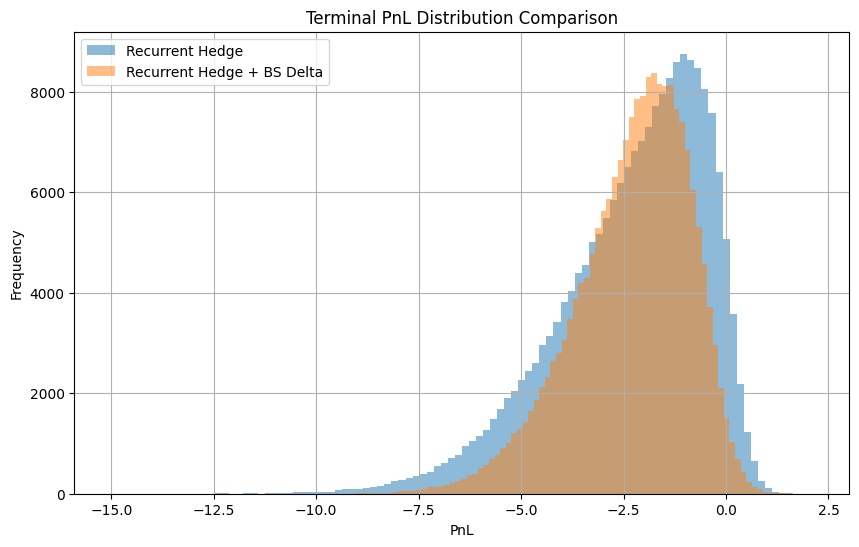

In [59]:
# --- Plot Histograms ---
plt.figure(figsize=(10,6))
for label in results:
    plt.hist(results[label]["pnl_array"], bins=100, alpha=0.5, label=label)
plt.title("Terminal PnL Distribution Comparison")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [60]:
def plot_side_by_side_hist(pnl1, pnl2, label1="Strategy A", label2="Strategy B",
                           bins=20, x_range=(-10, 10), title=None, save_path=None):
    """
    Plot side-by-side histograms for two PnL distributions with aligned bins.
    
    Args:
        pnl1, pnl2: numpy arrays of PnL values.
        label1, label2: labels for the two strategies.
        bins: number of histogram bins (default is 20 for wider bins).
        x_range: tuple, (min, max) for histogram x-axis.
        title: custom plot title. If None, generates one automatically.
        save_path: optional file path to save the plot.
    """
    counts1, edges = np.histogram(pnl1, bins=bins, range=x_range)
    counts2, _     = np.histogram(pnl2, bins=edges)

    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0

    plt.figure(figsize=(10, 6))
    plt.bar(centers - width/2, counts1, width=width, alpha=0.6, label=label1, color='tab:blue')
    plt.bar(centers + width/2, counts2, width=width, alpha=0.6, label=label2, color='tab:orange')

    plt.xlabel("Terminal Hedging PnL", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(title or f"Side-by-side PnL Histogram: {label1} vs. {label2}")
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


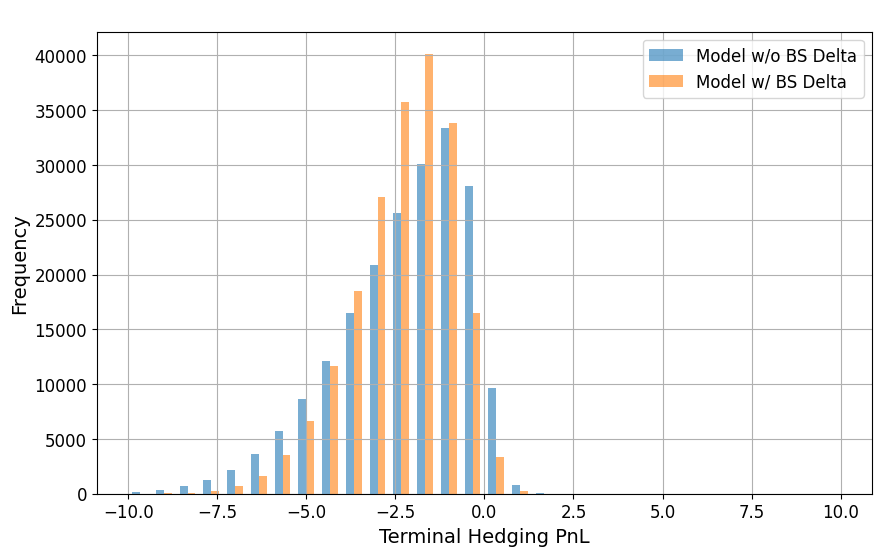

In [61]:
plot_side_by_side_hist(
    pnl1=results["Recurrent Hedge"]["pnl_array"],
    pnl2=results["Recurrent Hedge + BS Delta"]["pnl_array"],
    label1="Model w/o BS Delta",
    label2="Model w/ BS Delta",
    bins=30,
    x_range=(-10, 10),
    title=" "
)